In [6]:
import copy
import os

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

import numpy as np
import pandas as pd

from tslib.src import tsUtils
from tslib.src.synthcontrol.syntheticControl import RobustSyntheticControl

In [7]:
ts_pd1_df = pd.read_csv('data/km_pd1_df.csv')
ts_pd1_df.head(4)

,Cancer Type,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,Bladder Cancer,0.989583,0.958168,0.909721,0.849800,0.803864,0.780046,0.737052,0.697211,0.682982,...,0.546154,0.504935,0.493459,0.481123,0.455800,0.414364,0.414364,0.414364,0.396348,0.396348
1,Colorectal Cancer,1.000000,0.979798,0.919192,0.876439,0.832062,0.787086,0.775160,0.713640,0.701120,...,0.539263,0.519290,0.519290,0.495686,0.495686,0.495686,0.495686,0.460280,0.460280,0.460280
2,Glioma,0.991228,0.982378,0.928794,0.893071,0.847966,0.775799,0.730164,0.702782,0.656547,...,0.422849,0.368638,0.297289,0.272515,0.245263,0.231637,0.204386,0.177135,0.144928,0.144928
3,Head and Neck Cancer,1.000000,0.977099,0.884775,0.828471,0.767426,0.740963,0.713854,0.666890,0.607169,...,0.406892,0.386547,0.386547,0.386547,0.358937,0.358937,0.326306,0.290050,0.217537,0.217537


In [8]:
def predict_and_plot(ts_pd1_df, target_type, moStart=1, moTrainEnd=6, moTestEnd=12, singvals=2):
    other_types = list(ts_pd1_df['Cancer Type'])
    other_types.remove(target_type)
    months = [str(i) for i in range(moStart, moTestEnd + 1)]
    p = 1.0

    trainingMonths = [str(i) for i in range(moStart, moTrainEnd + 1)]
    testMonths = [str(i) for i in range(moTrainEnd + 1, moTestEnd + 1)]

    trainDataMasterDict = {}
    trainDataDict = {}
    testDataDict = {}
    for key in other_types:
      series = ts_pd1_df.loc[ts_pd1_df['Cancer Type'] == key]
      trainDataMasterDict.update({key: series[trainingMonths].values[0]})
      # randomly hide training data
      (trainData, pObservation) = tsUtils.randomlyHideValues(copy.deepcopy(trainDataMasterDict[key]), p)
      trainDataDict.update({key: trainData})
      testDataDict.update({key: series[testMonths].values[0]})
        
    series = ts_pd1_df[ts_pd1_df['Cancer Type'] == target_type]
    trainDataMasterDict.update({target_type: series[trainingMonths].values[0]})
    trainDataDict.update({target_type: series[trainingMonths].values[0]})
    testDataDict.update({target_type: series[testMonths].values[0]})

    trainMasterDF = pd.DataFrame(data=trainDataMasterDict)
    trainDF = pd.DataFrame(data=trainDataDict)
    testDF = pd.DataFrame(data=testDataDict)    
    
    rscModel = RobustSyntheticControl(
        target_type, singvals, len(trainDF), probObservation=1.0, modelType='svd',
        svdMethod='numpy', otherSeriesKeysArray=other_types)
    rscModel.fit(trainDF)
    denoisedDF = rscModel.model.denoisedDF()
    
    predictions = []
    predictions = np.dot(testDF[other_types], rscModel.model.weights)
    actual = ts_pd1_df.loc[ts_pd1_df['Cancer Type'] == target_type][months]
    actual = actual.iloc[0]
    model_fit = np.dot(trainDF[other_types][:], rscModel.model.weights)   
    
    fig, ax = plt.subplots(1,1)
    tick_spacing = 5
    # this is a bug in matplotlib
    label_markings = np.insert(months[::tick_spacing], 0, 'dummy')

    ax.set_xticks(np.arange(len(label_markings)))
    ax.set_xticklabels(label_markings, rotation=45)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    plt.plot(months, actual ,label='actual')
    plt.xlabel('Months after treatment')
    plt.ylabel('Survival rate')
    plt.plot(trainingMonths, model_fit, label='fitted model')
    plt.plot(testMonths, predictions, label='counterfactual')
    plt.title(target_type+', Singular Values used: '+str(singvals))

    xposition = pd.to_datetime(moTrainEnd,  errors='coerce')
    plt.axvline(x=str(moTrainEnd), color='k', linestyle='--', linewidth=4)
    plt.grid()
    plt.legend()

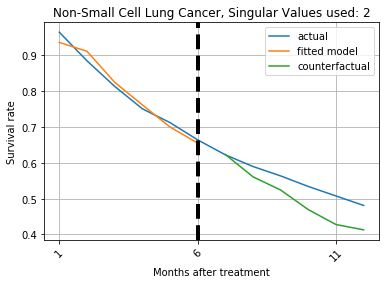

In [9]:
predict_and_plot(ts_pd1_df, 'Non-Small Cell Lung Cancer', moStart=1, moTrainEnd=6, moTestEnd=12, singvals=2)

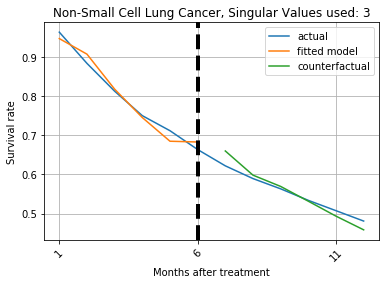

In [20]:
predict_and_plot(ts_pd1_df, 'Non-Small Cell Lung Cancer', moStart=1, moTrainEnd=6, moTestEnd=12, singvals=3)

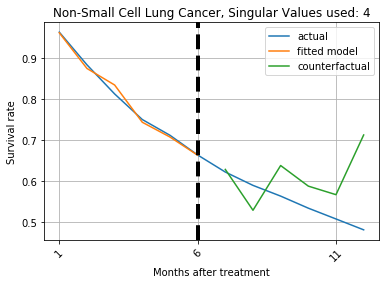

In [21]:
predict_and_plot(ts_pd1_df, 'Non-Small Cell Lung Cancer', moStart=1, moTrainEnd=6, moTestEnd=12, singvals=4)

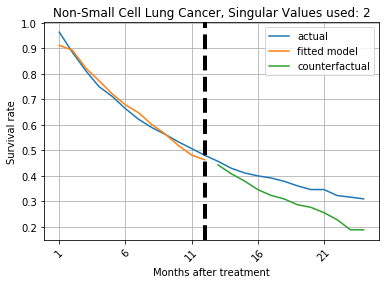

In [10]:
predict_and_plot(ts_pd1_df, 'Non-Small Cell Lung Cancer', moStart=1, moTrainEnd=12, moTestEnd=24, singvals=2)

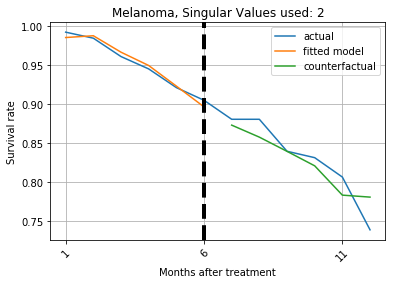

In [11]:
predict_and_plot(ts_pd1_df, 'Melanoma', moStart=1, moTrainEnd=6, moTestEnd=12, singvals=2)

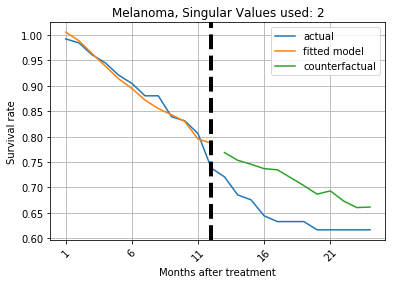

In [12]:
predict_and_plot(ts_pd1_df, 'Melanoma', moStart=1, moTrainEnd=12, moTestEnd=24, singvals=2)

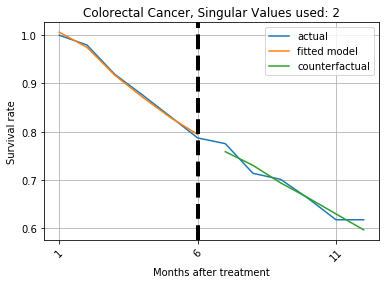

In [13]:
predict_and_plot(ts_pd1_df, 'Colorectal Cancer', moStart=1, moTrainEnd=6, moTestEnd=12, singvals=2)

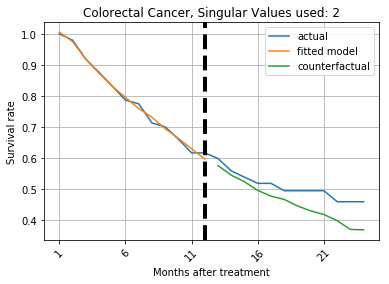

In [14]:
predict_and_plot(ts_pd1_df, 'Colorectal Cancer', moStart=1, moTrainEnd=12, moTestEnd=24, singvals=2)

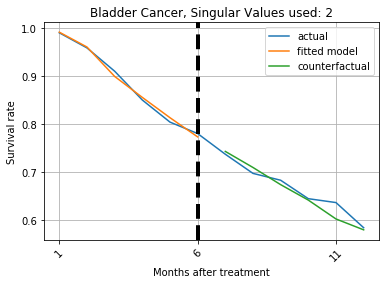

In [15]:
predict_and_plot(ts_pd1_df, 'Bladder Cancer', moStart=1, moTrainEnd=6, moTestEnd=12, singvals=2)

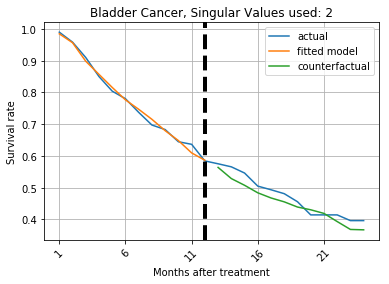

In [16]:
predict_and_plot(ts_pd1_df, 'Bladder Cancer', moStart=1, moTrainEnd=12, moTestEnd=24, singvals=2)

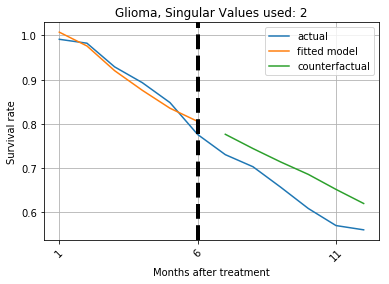

In [17]:
predict_and_plot(ts_pd1_df, 'Glioma', moStart=1, moTrainEnd=6, moTestEnd=12, singvals=2)

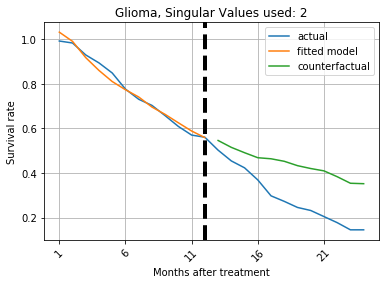

In [18]:
predict_and_plot(ts_pd1_df, 'Glioma', moStart=1, moTrainEnd=12, moTestEnd=24, singvals=2)